# PCA 範例
* 以 PCA + 邏輯斯迴歸判斷手寫辨識資料集, 觀察不同 component 下正確率的變化

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import time

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [117]:
logistic = SGDClassifier(loss='log', penalty='l1', max_iter=100, tol=1e-5, random_state=0)
pca = PCA()

pipe = Pipeline(steps=[('pca', pca),
                       ('logistic', logistic)])

digits = datasets.load_digits()
X = digits.data
y = digits.target
print(f'X.shape: {X.shape}, y.shape: {y.shape}')

X.shape: (1797, 64), y.shape: (1797,)


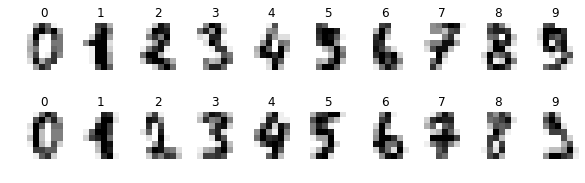

In [4]:
fig, axes = plt.subplots(2, 10, figsize=(10, 3))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i].reshape(8, 8), cmap=plt.cm.binary)
    ax.axis('off')
    ax.set_title(y[i])

# 作業
* 將參數 penalty 改為 L1, max_iter 改為 100, 觀察 PCA 與羅吉斯迴歸做手寫辨識的效果

In [143]:
def parameter_tuning(model, params, data, target):
    
    t0 = time.time()
    search = GridSearchCV(pipe, param_grid, iid=False, cv=5, n_jobs=-1)
    search.fit(data, target)
    t1 = time.time()
    print(f"Best accuracy: {search.best_score_:.3f}")
    print(f"Best parameters: {search.best_params_}")
    print(f"Avg. time to fit: {search.cv_results_['mean_fit_time'].mean():.3f}")
    print(f"Avg. time to predict: {search.cv_results_['mean_score_time'].mean():.3f}")
    print(f'Search time: {(t1 - t0):.4f}')
    
    return search
          
          
def accuracy(model, data, target, test_size=0.25, random_state=0):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size, random_state=random_state)
    
    df = pd.DataFrame({}, columns=['n_components', 'accuracy', 'precision', 'recall', 'f1'])
    df['n_components'] = model.param_grid['pca__n_components']
    accuracy_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    
    for n in model.param_grid['pca__n_components']:
        pca = dict(model.estimator.steps)['pca'].set_params(n_components=n)
        pca.fit(X_train)
        X_train_pca = pca.transform(X_train)
        X_test_pca = pca.transform(X_test)
        
        clf = dict(search.best_estimator_.steps)['logistic']
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_test_pca)
        accuracy_scores.append(metrics.accuracy_score(y_test, y_pred))
        precision_scores.append(metrics.precision_score(y_test, y_pred, average='macro'))
        recall_scores.append(metrics.recall_score(y_test, y_pred, average='macro'))
        f1_scores.append(metrics.f1_score(y_test, y_pred, average='macro'))
          
        con_mat = metrics.confusion_matrix(y_test, y_pred)
        plot_confusion_matrix(cm=con_mat, 
                              target_names=np.unique(digits.target), 
                              subtitle=': PCA with %d components' % n,
                              normalize=False)
    
    df['accuracy'] = accuracy_scores
    df['precision'] = precision_scores
    df['recall'] = recall_scores
    df['f1'] = f1_scores
    
    return df

In [115]:
# 執行 GridSearchCV 跑出最佳參數
n_components = [4, 8, 16, 24, 32, 40, 48, 56, 64]
alpha = np.logspace(-4, 4, 5)

param_grid = {
    'pca__n_components': n_components,
    'logistic__alpha': alpha,
}

search = parameter_tuning(pipe, param_grid, X, y)

Best accuracy: 0.918
Best parameters: {'logistic__alpha': 0.01, 'pca__n_components': 24}
Avg. time to fit: 0.639
Avg. time to predict: 0.006
Search time: 22.2736


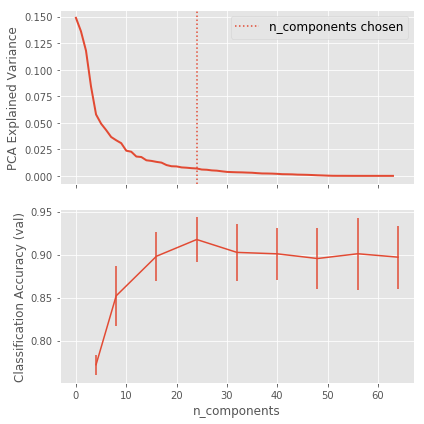

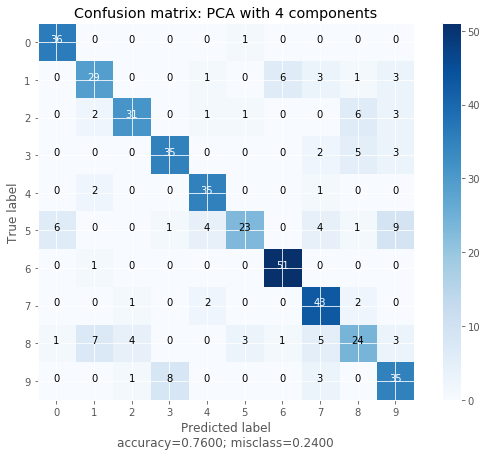

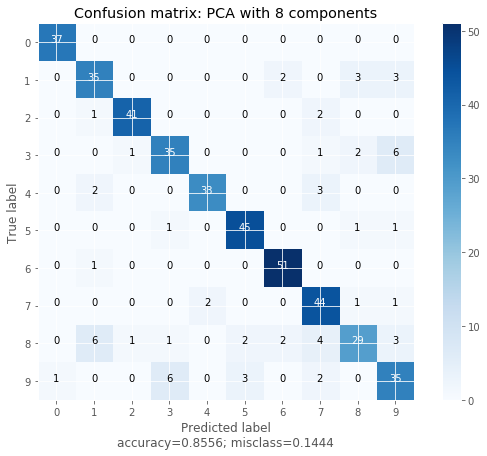

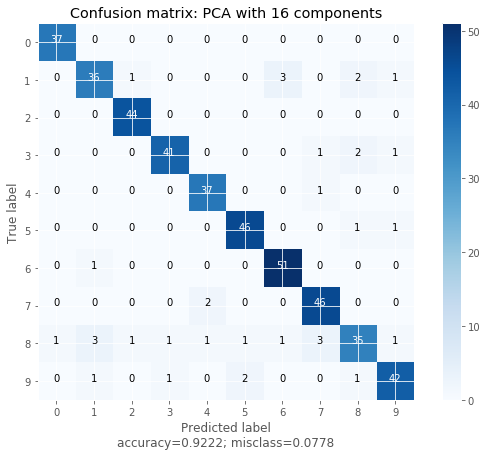

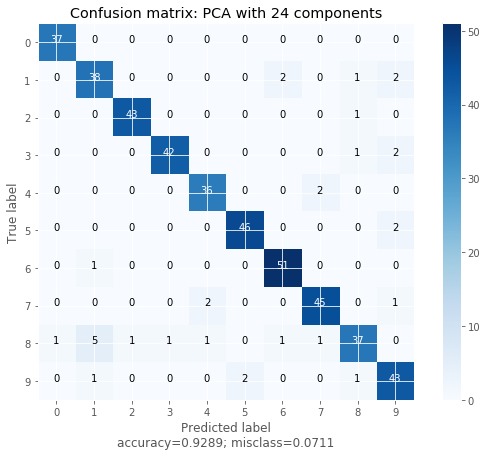

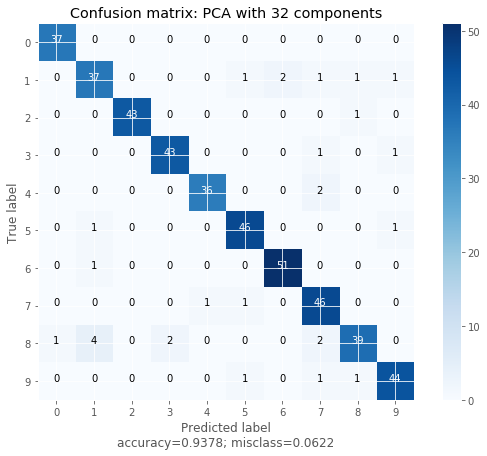

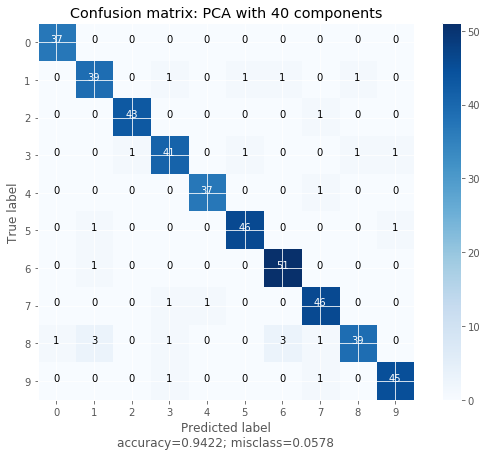

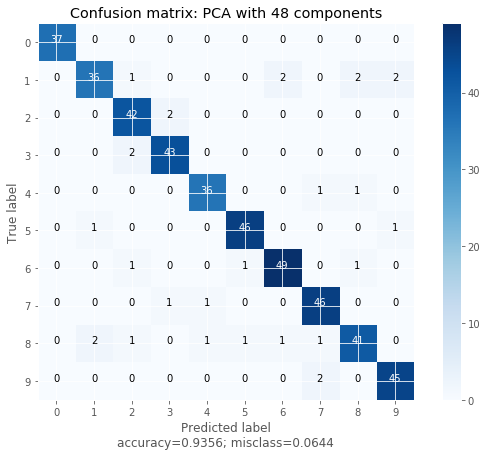

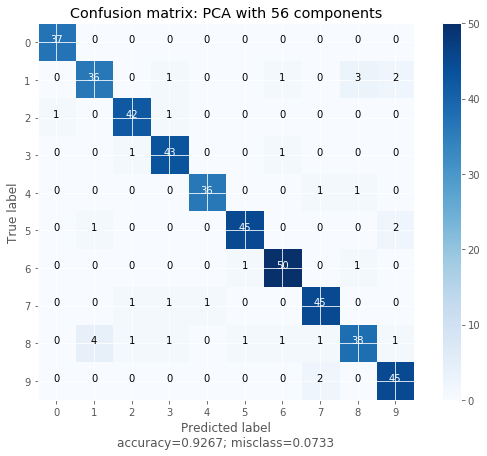

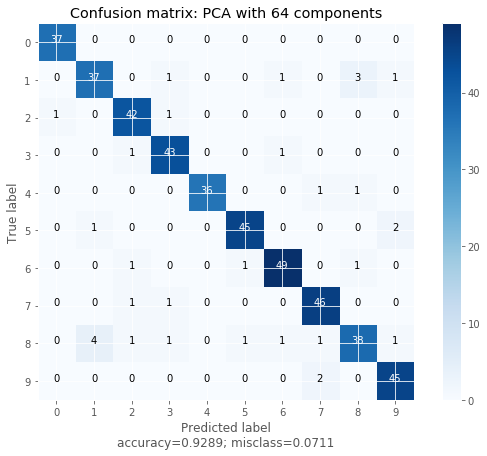

,n_components,accuracy,precision,recall,f1
0,4,0.760000,0.763781,0.765122,0.755949
1,8,0.855556,0.859459,0.857575,0.856165
2,16,0.922222,0.922145,0.924222,0.922288
3,24,0.928889,0.929794,0.930402,0.929334
4,32,0.937778,0.939638,0.938677,0.938480
5,40,0.942222,0.943639,0.943643,0.942952
6,48,0.935556,0.936810,0.936527,0.936205
7,56,0.926667,0.927586,0.928033,0.927300
8,64,0.928889,0.930442,0.930519,0.929946


In [144]:
# 繪製不同 components 的 PCA explained variance ratio
pca.fit(X)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA Explained Variance')
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, 
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

# 繪製不同採樣點的 accuracy
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(lambda x: x.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score', legend=False, ax=ax1)
ax1.set_ylabel('Classification Accuracy (val)')
ax1.set_xlabel('n_components')
plt.tight_layout()
plt.show()

accuracy(search, X, y)

In [137]:
def plot_confusion_matrix(cm,
                          target_names,
                          subtitle, 
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title+str(subtitle))
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()